In this notebook I am going to show few extended examples of what you can do with this loader (or more with `tf.data.Dataset` in general).

First we will install the loader:

In [1]:
!pip install -e git+git://github.com/sebastian-sz/tfdata-image-loader.git#egg=tfdata-image-loader

Obtaining tfdata-image-loader from git+git://github.com/sebastian-sz/tfdata-image-loader.git#egg=tfdata-image-loader
  Cloning git://github.com/sebastian-sz/tfdata-image-loader.git to ./src/tfdata-image-loader
  Running command git clone -q git://github.com/sebastian-sz/tfdata-image-loader.git /content/src/tfdata-image-loader
  Running setup.py develop for tfdata-image-loader


and restart runtime (if on Colab):

In [ ]:
import os

def restart_runtime():
  os.kill(os.getpid(), 9)

restart_runtime()

### Download and unpack example dataset:

In [1]:
!curl https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz |tar xzf -

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  218M  100  218M    0     0  44.6M      0  0:00:04  0:00:04 --:--:-- 47.2M


Remove the license file so it doesn't mess up our directory tree structure:

In [2]:
!rm flower_photos/LICENSE.txt

Define few helpful constants:

In [3]:
import os
import pathlib
import time

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tfdata_image_loader import TFDataImageLoader

tf.__version__

'2.4.1'

In [4]:
EPOCHS = 10
INPUT_SHAPE = (1, 224, 224, 3)

BATCH_SIZE = 8

DATA_PATH = "./flower_photos/"
NUM_CLASSES = len(os.listdir(DATA_PATH))

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

IMG_HEIGHT = IMG_WIDTH = INPUT_SHAPE[1]

##### Example 1. Use Tensorflow Addons:

We can use [Tensorflow Addons](https://www.tensorflow.org/addons) (tfa) to further modify the data.

First, I will declare a normal loader and show the image. Then, I will apply tfa
data modification.

In [5]:
!pip install tensorflow-addons

     |████████████████████████████████| 706kB 9.7MB/s 


In [6]:
import tensorflow_addons as tfa

In [7]:
def preprocess_data(image, label):
    return image / 255., label

In [8]:
data_loader = TFDataImageLoader(
    data_path=DATA_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=False,
    pre_process_function=preprocess_data,
)

Found 3670 images, belonging to 5 classes

Class names mapping: 
{'daisy': array([1, 0, 0, 0, 0], dtype=int32), 'dandelion': array([0, 1, 0, 0, 0], dtype=int32), 'roses': array([0, 0, 1, 0, 0], dtype=int32), 'sunflowers': array([0, 0, 0, 1, 0], dtype=int32), 'tulips': array([0, 0, 0, 0, 1], dtype=int32)}



In [9]:
normal_dataset = data_loader.load_dataset()

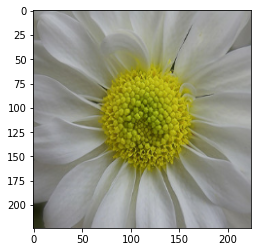

In [10]:
for image, _ in normal_dataset.take(1):
  first_image = image[0]
  plt.imshow(first_image)

In [11]:
def tfa_preprocess_data(image, label):
  image = image / 255.
  image = tfa.image.mean_filter2d(image, filter_shape=11)
  return image, label

In [12]:
augmented_data_loader = TFDataImageLoader(
    data_path=DATA_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=False,
    pre_process_function=tfa_preprocess_data,
)

augmented_dataset = augmented_data_loader.load_dataset()

Found 3670 images, belonging to 5 classes

Class names mapping: 
{'daisy': array([1, 0, 0, 0, 0], dtype=int32), 'dandelion': array([0, 1, 0, 0, 0], dtype=int32), 'roses': array([0, 0, 1, 0, 0], dtype=int32), 'sunflowers': array([0, 0, 0, 1, 0], dtype=int32), 'tulips': array([0, 0, 0, 0, 1], dtype=int32)}



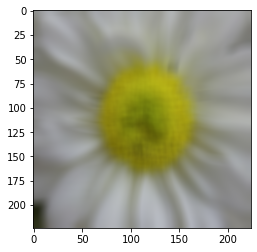

In [13]:
for image, _ in augmented_dataset.take(1):
  first_image = image[0]
  plt.imshow(first_image)

##### Example 2: Load the dataset as numpy array's:

We can use Tensorflow Datasets (`tfds`) to convert the dataset entirely to numpy arrays generator:

In [14]:
import tensorflow_datasets as tfds

tfds.__version__

'4.0.1'

In [15]:
numpy_ds = tfds.as_numpy(normal_dataset)

In [16]:
for image, label in numpy_ds:
  print(image.shape)
  print(label.shape)

  assert isinstance(image, np.ndarray)
  assert isinstance(label, np.ndarray)

  break

(8, 224, 224, 3)
(8, 5)


##### Example 3. Use albumentations and `numpy_function` to apply further modify data.


(Since we are not operating on `tf.Tensors` we can expect some negative impact on the performance.)

In [17]:
import albumentations as A

In [18]:
transform = A.RandomBrightness(limit=2.2)

In [19]:
def augment_data(image, label):
  augmented_image = transform(image=image)['image']
  return augmented_image, label

Now, by default inside `tf.data`'s `.map` function we are operating on Graph Tensor's. Let's see what happens if we apply the augmentation directly:

In [20]:
faulty_albumentations_data_loader = TFDataImageLoader(
    data_path=DATA_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=False,
    pre_process_function=preprocess_data,
    augmentation_function=augment_data,
)

Found 3670 images, belonging to 5 classes

Class names mapping: 
{'daisy': array([1, 0, 0, 0, 0], dtype=int32), 'dandelion': array([0, 1, 0, 0, 0], dtype=int32), 'roses': array([0, 0, 1, 0, 0], dtype=int32), 'sunflowers': array([0, 0, 0, 1, 0], dtype=int32), 'tulips': array([0, 0, 0, 0, 1], dtype=int32)}



In [21]:
## THIS WILL THROW ERROR.


## Whoops not a numpy array:
faulty_loader = faulty_albumentations_data_loader.load_dataset()

AttributeError: ignored

(After few tries) The above threw an error because albumentations expects numpy. Let's rewrite the `augment_data` so that it's content is in numpy:

In [22]:
def numpy_augment_data(image, label):
  func = tf.numpy_function(func=augment_data, inp=[image, label], Tout=[tf.float32, tf.int32])
  return func

In [23]:
albumentations_data_loader = TFDataImageLoader(
    data_path=DATA_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=False,
    pre_process_function=preprocess_data,
    augmentation_function=numpy_augment_data,
)

albumentations_dataset = albumentations_data_loader.load_dataset()

Found 3670 images, belonging to 5 classes

Class names mapping: 
{'daisy': array([1, 0, 0, 0, 0], dtype=int32), 'dandelion': array([0, 1, 0, 0, 0], dtype=int32), 'roses': array([0, 0, 1, 0, 0], dtype=int32), 'sunflowers': array([0, 0, 0, 1, 0], dtype=int32), 'tulips': array([0, 0, 0, 0, 1], dtype=int32)}



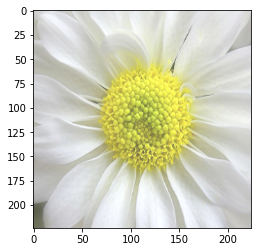

In [24]:
for image, label in albumentations_dataset.take(1):
  plt.imshow(image[0])

Be aware that using `tf.numpy_function` will result in performance penalty.